In [2]:
from pathlib import Path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

os.environ["WANDB_SILENT"] = "true"

from pathlib import Path
import numpy as np
import pandas as pd

In [3]:
data_path = "../data/"
"""
Build `X_train_mean, X_val_mean, X_train, X_val, y_train, y_val`
TODO: add other aggregation that mean (e.g. max) ? Use a dict ?
"""

# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path(data_path)

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train_val = pd.read_csv(data_dir / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir / "supplementary_data" / "test_metadata.csv")


# concatenate y_train_val and df_train_val
y_train_val = pd.read_csv(data_dir / "train_output.csv")
df_train_val = df_train_val.merge(y_train_val, on="Sample ID")


In [4]:
def hausdorf_matrix_single(bags):
    """Hausdorf distance for a single set of bags."""
    n = bags.shape[0]
    hausdorf = np.zeros((n, n, 3))
    for i in tqdm(range(n)):
        for j in range(i, n):
            dist = np.einsum('ij,ij->i', bags[i], bags[i])[:,None] + np.einsum('ij,ij->i', bags[j], bags[j]) - 2 * np.dot(bags[i], bags[j].T)
            
            min1 = np.min(dist, axis=-1)
            min2 = np.min(dist, axis=0)

            # Vanilla Hausdorf
            dist1 = np.max(min1)
            dist2 = np.max(min2)
            H_max = max(dist1, dist2)

            # Mean Hausdorf
            H_mean = (np.sum(min1) + np.sum(min2)) / (np.size(min1) + np.size(min2)) 

            # Min Hausdorf
            H_min = np.min(min1)

            hausdorf[i, j] = np.array([H_max, H_mean, H_min])
            hausdorf[j, i] = np.array([H_max, H_mean, H_min])
    return hausdorf

def hausdorf_matrix_dual(bags_pred, bags_train):
    """Hausdorf distance between two set of bags."""
    n = bags_pred.shape[0]
    m = bags_train.shape[0]
    hausdorf = np.zeros((n, m, 3))
    for i in tqdm(range(n)):
        for j in range(m):
            dist = np.einsum('ij,ij->i', bags_pred[i], bags_pred[i])[:,None] + np.einsum('ij,ij->i', bags_train[j], bags_train[j]) - 2 * np.dot(bags_pred[i], bags_train[j].T)
            
            min1 = np.min(dist, axis=-1)
            min2 = np.min(dist, axis=0)

            # Vanilla Hausdorf
            dist1 = np.max(min1)
            dist2 = np.max(min2)
            H_max = max(dist1, dist2)

            # Mean Hausdorf
            H_mean = (np.sum(min1) + np.sum(min2)) / (np.size(min1) + np.size(min2)) 

            # Min Hausdorf
            H_min = np.min(min1)

            hausdorf[i, j] = np.array([H_max, H_mean, H_min])
    return hausdorf

In [5]:
# Path for normalization factor
data_norm_path = Path('../data/expo_lambda')

center_list = ['C_1', 'C_2', 'C_5']
X_dict = {}
y_dict = {}

# Extract and normalize
for center_curr in center_list:
    X_train = []
    y_train = []

    for sample, label, center, patient in df_train_val[
        ["Sample ID", "Target", "Center ID", "Patient ID"]
    ].values:
        if center == center_curr:
            # load the coordinates and features (1000, 3+2048)
            _features = np.load(train_features_dir / sample)
            # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
            # and the MoCo V2 features
            coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
            X_train.append(features)
            y_train.append(label)

    # convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # normalize
    norm_factor = np.load(data_norm_path / f'{center_curr}.npy')
    X_train = X_train / norm_factor

    X_dict[center_curr] = X_train
    y_dict[center_curr] = y_train

In [6]:
# for center in center_list:
#     X = X_dict[center]
#     matrix = hausdorf_matrix_single(X)
#     np.save(f'hausdorf_mean_norm_{center}.npy', matrix)

# center1 = 'C_1'
# for center2 in center_list:
#     if center1 != center2:
#         X1 = X_dict[center1]
#         X2 = X_dict[center2]
#         matrix = hausdorf_matrix_dual(X1, X2)
#         np.save(f'hausdorf_mean_norm_{center1}_{center2}.npy', matrix)

# center1 = 'C_2'
# center2 = 'C_5'
# X1 = X_dict[center1]
# X2 = X_dict[center2]
# matrix = hausdorf_matrix_dual(X1, X2)
# np.save(f'hausdorf_mean_norm_{center1}_{center2}.npy', matrix)

In [7]:
def get_matrices(center1, center2, center_test, y_dict, norm=''):

    y1 = y_dict[center1]
    y2 = y_dict[center2]
    y_train = np.concatenate((y1, y2))
    y_test = y_dict[center_test]
    
    n1 = y1.size
    n2 = y2.size
    n_train = n1 + n2
    n_test = y_test.size

    name = 'hausdorf'
    if norm != '':
        name += '_' + norm

    distances_train = np.zeros((n_train, n_train, 3))
    distances_train[:n1, :n1] = np.load(f'{name}_{center1}.npy')
    distances_train[n1:, n1:] = np.load(f'{name}_{center2}.npy')
    distances_train[:n1, n1:] = np.load(f'{name}_{center1}_{center2}.npy')
    distances_train[n1:, :n1] = np.moveaxis(np.load(f'{name}_{center1}_{center2}.npy'), 0, 1)
    distances_train[distances_train < 0] = 0

    distances_pred = np.zeros((n_train, n_test, 3))
    if center1 < center_test:
        distances_pred[:n1] = np.load(f'{name}_{center1}_{center_test}.npy')
    else:
        distances_pred[:n1] = np.moveaxis(np.load(f'{name}_{center_test}_{center1}.npy'), 0, 1)
    
    if center2 < center_test:
        distances_pred[n1:] = np.load(f'{name}_{center2}_{center_test}.npy')
    else:
        distances_pred[n1:] = np.moveaxis(np.load(f'{name}_{center_test}_{center2}.npy'), 0, 1)
    distances_pred[distances_pred < 0] = 0

    return distances_train, y_train, distances_pred, y_test

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

def plot_roc(distances_train, y_train, distances_pred, y_test, n_max=60):
    n_neighbors = np.arange(1, n_max)
    fig, axs = plt.subplots(3)
    distance = ['classic', 'mean', 'min']

    roc_auc = np.zeros((n_neighbors.size, 3), dtype=float)
    roc_auc_weight = np.zeros((n_neighbors.size, 3), dtype=float)

    for hausdorf_type in range(3):

        for n_neighbor in n_neighbors: 
            classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed")
            classifier.fit(distances_train[:,:,hausdorf_type], y_train)
            y_pred = classifier.predict_proba(distances_pred[:,:,hausdorf_type].T)
            roc_auc[n_neighbor - 1, hausdorf_type] = roc_auc_score(y_test, y_pred[:, 1])

            classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed", weights="distance")
            classifier.fit(distances_train[:,:,hausdorf_type], y_train)
            y_pred = classifier.predict_proba(distances_pred[:,:,hausdorf_type].T)
            roc_auc_weight[n_neighbor - 1, hausdorf_type] = roc_auc_score(y_test, y_pred[:, 1])

        axs[hausdorf_type].set_title(distance[hausdorf_type])
        axs[hausdorf_type].plot(roc_auc[:, hausdorf_type], label='number')
        axs[hausdorf_type].plot(roc_auc_weight[:, hausdorf_type], label='weight')
        axs[hausdorf_type].legend(loc='best')

        print(f'For {distance[hausdorf_type]}, the roc auc is {roc_auc[:, hausdorf_type].max()} with k = {n_neighbors[roc_auc[:, hausdorf_type].argmax()]}')
        print(f'For {distance[hausdorf_type]}_weight, the roc auc is {roc_auc_weight[:, hausdorf_type].max()} with k = {n_neighbors[roc_auc_weight[:, hausdorf_type].argmax()]}')
    plt.show()

    return roc_auc, roc_auc_weight


# No normalization

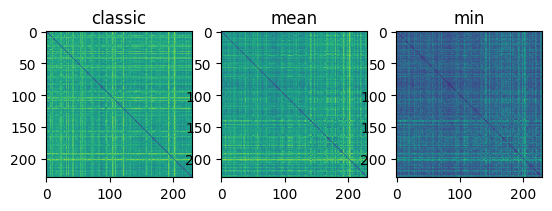

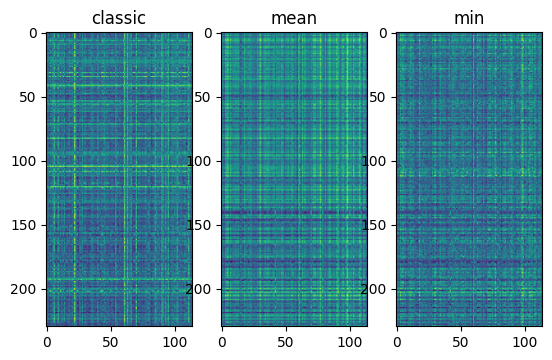

In [42]:
list_cross_val_train = [['C_1', 'C_2'], ['C_1', 'C_5'], ['C_2', 'C_5']]
list_cross_val_test = ['C_5', 'C_2', 'C_1']

center1, center2 = list_cross_val_train[0]
center_test = list_cross_val_test[0]

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict)

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_train[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_train[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_train[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_pred[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_pred[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_pred[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

C_1, C_2 as train set and C_5 as test set
For classic, the roc auc is 0.5346867007672634 with k = 19
For classic_weight, the roc auc is 0.5271739130434783 with k = 19
For mean, the roc auc is 0.6632033248081841 with k = 55
For mean_weight, the roc auc is 0.6547314578005117 with k = 55
For min, the roc auc is 0.6735933503836316 with k = 57
For min_weight, the roc auc is 0.653772378516624 with k = 57


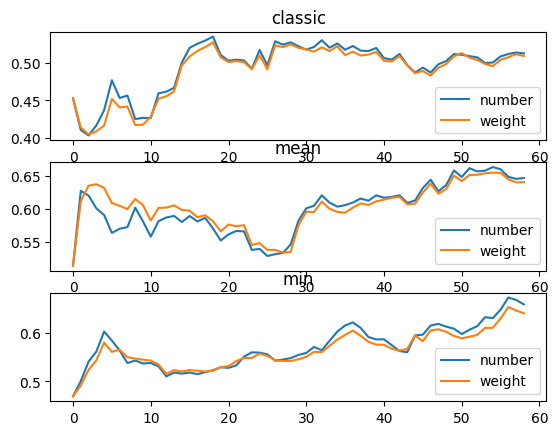

C_1, C_5 as train set and C_2 as test set
For classic, the roc auc is 0.5403184386235234 with k = 20
For classic_weight, the roc auc is 0.5269645608628659 with k = 14
For mean, the roc auc is 0.6471494607087828 with k = 49
For mean_weight, the roc auc is 0.6363636363636364 with k = 49
For min, the roc auc is 0.5790960451977402 with k = 27
For min_weight, the roc auc is 0.5814072932717002 with k = 27


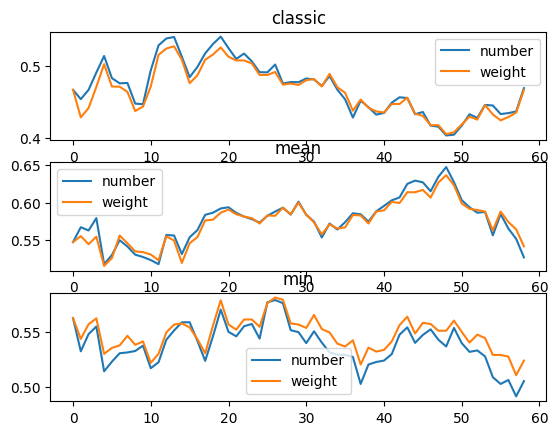

C_2, C_5 as train set and C_1 as test set
For classic, the roc auc is 0.47431781701444625 with k = 37
For classic_weight, the roc auc is 0.4634258197661087 with k = 42
For mean, the roc auc is 0.616945654666361 with k = 20
For mean_weight, the roc auc is 0.6248566842467325 with k = 20
For min, the roc auc is 0.5989451960559504 with k = 21
For min_weight, the roc auc is 0.5920660398991057 with k = 23


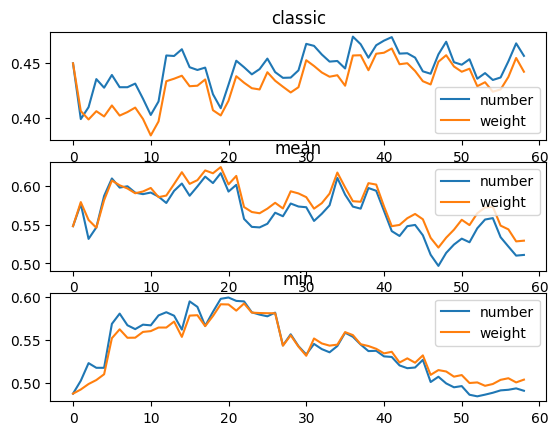

Mean of the cross val


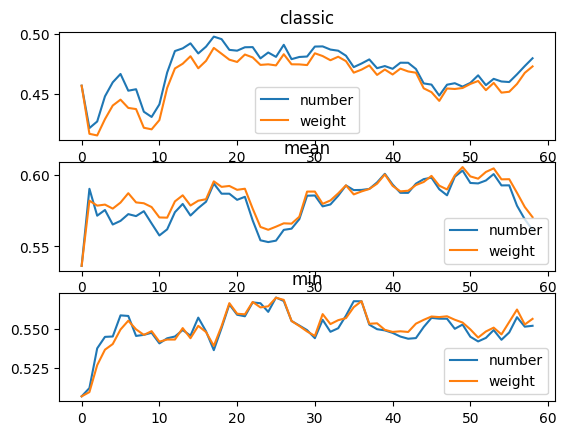

In [53]:
n_max = 60
roc_auc_sum = np.zeros((n_max - 1, 3))
roc_auc_weight_sum = np.zeros((n_max - 1, 3))

for i in range(len(list_cross_val_train)):
    center1, center2 = list_cross_val_train[i]
    center_test = list_cross_val_test[i]
    print(f'{center1}, {center2} as train set and {center_test} as test set')
    
    distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict)
    roc_auc, roc_auc_weight = plot_roc(distances_train, y_train, distances_pred, y_test, n_max=60)
    
    roc_auc_sum += roc_auc / 3 
    roc_auc_weight_sum += roc_auc_weight / 3 

print("Mean of the cross val")

fig, axs = plt.subplots(3)
distance = ['classic', 'mean', 'min']
for hausdorf_type in range(3):
    axs[hausdorf_type].set_title(distance[hausdorf_type])
    axs[hausdorf_type].plot(roc_auc_sum[:, hausdorf_type], label='number')
    axs[hausdorf_type].plot(roc_auc_weight_sum[:, hausdorf_type], label='weight')
    axs[hausdorf_type].legend(loc='best')
plt.show()


In [45]:
center1 = 'C_1'
center2 = 'C_2' 
center_test = 'C_5' 

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict)

n1, n2, _ = distances_pred.shape

distances_matrix = np.zeros((n1 + n2, n1 + n2, 3))
distances_matrix[:n1, :n1] = distances_train
distances_matrix[:n1, n1:] = distances_pred
distances_matrix[n1:, :n1] = np.moveaxis(distances_pred, 0, 1)
distances_matrix[n1:, n1:] = np.load(f'hausdorf_{center_test}.npy')

y = np.zeros(n1 + n2)
y[:n1] = y_train
y[n1:] = y_test

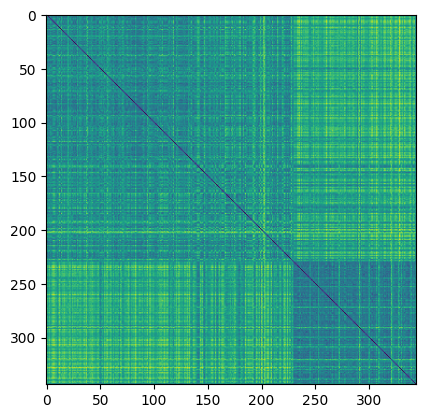

In [46]:
plt.imshow(distances_matrix[:,:,1])

# Exp norm

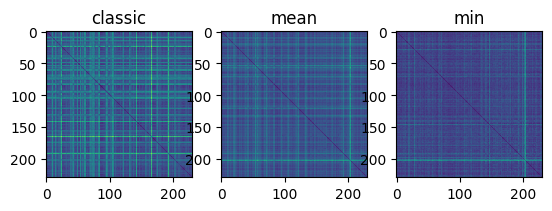

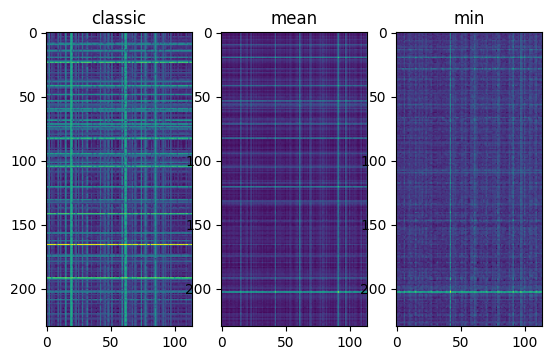

In [47]:
list_cross_val_train = [['C_1', 'C_2'], ['C_1', 'C_5'], ['C_2', 'C_5']]
list_cross_val_test = ['C_5', 'C_2', 'C_1']

center1, center2 = list_cross_val_train[0]
center_test = list_cross_val_test[0]

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='exp_norm')

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_train[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_train[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_train[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_pred[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_pred[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_pred[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

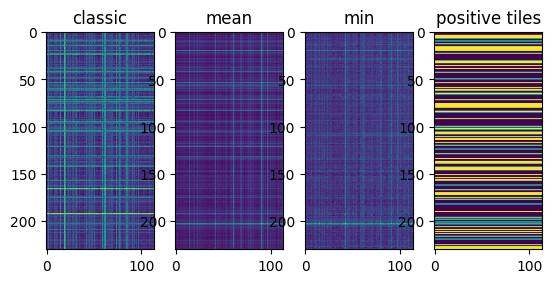

In [48]:
plt.subplot(141)
plt.title('classic')
plt.imshow(distances_pred[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(142)
plt.title('mean')
plt.imshow(distances_pred[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(143)
plt.title('min')
plt.imshow(distances_pred[:,:, 2] / distances_train[:,:, 2].max())
plt.subplot(144)
plt.title('positive tiles')
plt.imshow((distances_pred[:, :, 0] * y_train[:, None]) != 0)
plt.show()

C_1, C_2 as train set and C_5 as test set
For classic, the roc auc is 0.6245204603580563 with k = 8
For classic_weight, the roc auc is 0.6192455242966752 with k = 59
For mean, the roc auc is 0.730658567774936 with k = 52
For mean_weight, the roc auc is 0.7359335038363171 with k = 52
For min, the roc auc is 0.6013427109974424 with k = 41
For min_weight, the roc auc is 0.5994245524296675 with k = 41


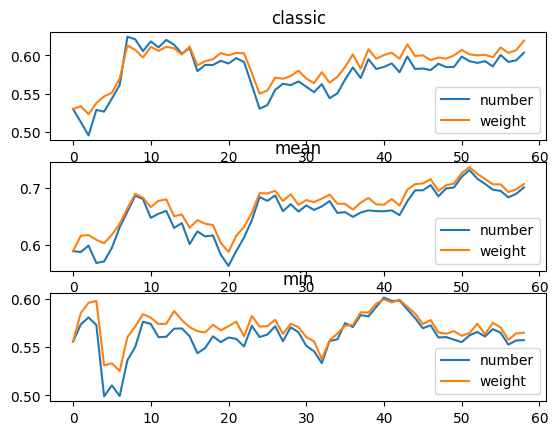

C_1, C_5 as train set and C_2 as test set
For classic, the roc auc is 0.699537750385208 with k = 9
For classic_weight, the roc auc is 0.7031330251669234 with k = 9
For mean, the roc auc is 0.6191576784797125 with k = 4
For mean_weight, the roc auc is 0.6142783769902415 with k = 15
For min, the roc auc is 0.5621468926553673 with k = 10
For min_weight, the roc auc is 0.5546995377503853 with k = 10


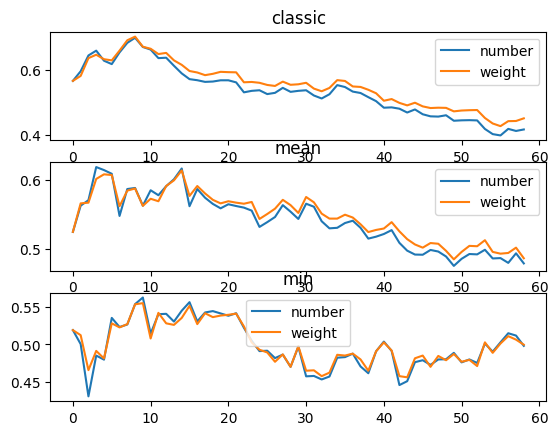

C_2, C_5 as train set and C_1 as test set
For classic, the roc auc is 0.5548039440495299 with k = 18
For classic_weight, the roc auc is 0.5521669341894061 with k = 18
For mean, the roc auc is 0.6159137812428342 with k = 29
For mean_weight, the roc auc is 0.6182068332951158 with k = 29
For min, the roc auc is 0.5830084842925934 with k = 15
For min_weight, the roc auc is 0.5741802338913095 with k = 15


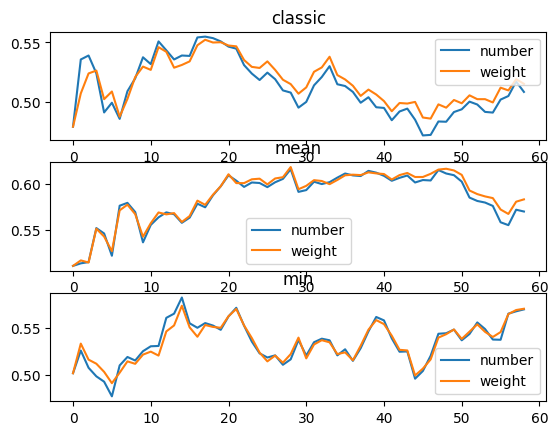

Mean of the cross val


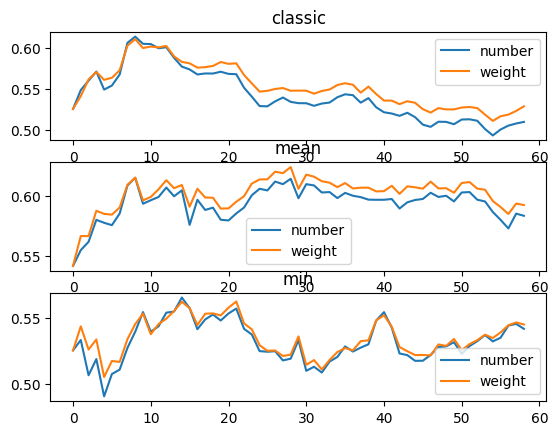

In [64]:
n_max = 60
roc_auc_sum = np.zeros((n_max - 1, 3))
roc_auc_weight_sum = np.zeros((n_max - 1, 3))

for i in range(len(list_cross_val_train)):
    center1, center2 = list_cross_val_train[i]
    center_test = list_cross_val_test[i]
    print(f'{center1}, {center2} as train set and {center_test} as test set')
    
    distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='exp_norm')
    roc_auc, roc_auc_weight = plot_roc(distances_train, y_train, distances_pred, y_test, n_max=60)
    
    roc_auc_sum += roc_auc / 3 
    roc_auc_weight_sum += roc_auc_weight / 3 

print("Mean of the cross val")

fig, axs = plt.subplots(3)
distance = ['classic', 'mean', 'min']
for hausdorf_type in range(3):
    axs[hausdorf_type].set_title(distance[hausdorf_type])
    axs[hausdorf_type].plot(roc_auc_sum[:, hausdorf_type], label='number')
    axs[hausdorf_type].plot(roc_auc_weight_sum[:, hausdorf_type], label='weight')
    axs[hausdorf_type].legend(loc='best')
plt.show()


In [65]:
print('Classic Hausdorf: ', roc_auc_weight_sum[:, 0].max(), roc_auc_weight_sum[:, 0].argmax())
print('AVG Hausdorf: ', roc_auc_weight_sum[:, 1].max(), roc_auc_weight_sum[:, 1].argmax())
print('Min Hausdorf: ', roc_auc_weight_sum[:, 2].max(), roc_auc_weight_sum[:, 2].argmax())

Classic Hausdorf:  0.6104038793820223 8
AVG Hausdorf:  0.6235900963908476 28
Min Hausdorf:  0.5626597849119603 21


In [58]:
center1 = 'C_1'
center2 = 'C_2' 
center_test = 'C_5' 

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='exp_norm')

n1, n2, _ = distances_pred.shape

distances_matrix = np.zeros((n1 + n2, n1 + n2, 3))
distances_matrix[:n1, :n1] = distances_train
distances_matrix[:n1, n1:] = distances_pred
distances_matrix[n1:, :n1] = np.moveaxis(distances_pred, 0, 1)
distances_matrix[n1:, n1:] = np.load(f'hausdorf_exp_norm_{center_test}.npy')

y = np.zeros(n1 + n2)
y[:n1] = y_train
y[n1:] = y_test

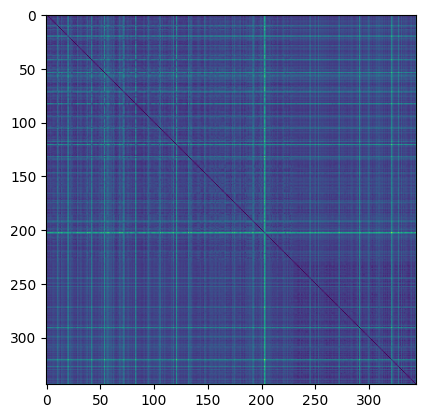

In [59]:
plt.imshow(distances_matrix[:,:,1])

# Mean Norm

C_1, C_2 as train set and C_5 as test set
For classic, the roc auc is 0.6801470588235293 with k = 45
For classic_weight, the roc auc is 0.6867007672634271 with k = 45
For mean, the roc auc is 0.640505115089514 with k = 14
For mean_weight, the roc auc is 0.6777493606138107 with k = 14
For min, the roc auc is 0.6419437340153453 with k = 19
For min_weight, the roc auc is 0.6288363171355499 with k = 19


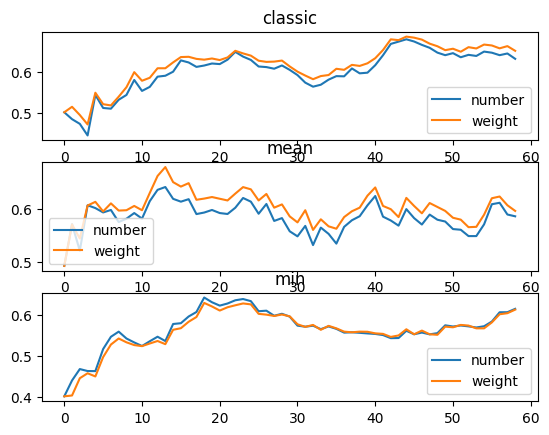

C_1, C_5 as train set and C_2 as test set
For classic, the roc auc is 0.5564971751412429 with k = 1
For classic_weight, the roc auc is 0.5711350796096559 with k = 2
For mean, the roc auc is 0.5998972778633795 with k = 28
For mean_weight, the roc auc is 0.595788392398562 with k = 28
For min, the roc auc is 0.6129943502824858 with k = 8
For min_weight, the roc auc is 0.6117103235747304 with k = 8


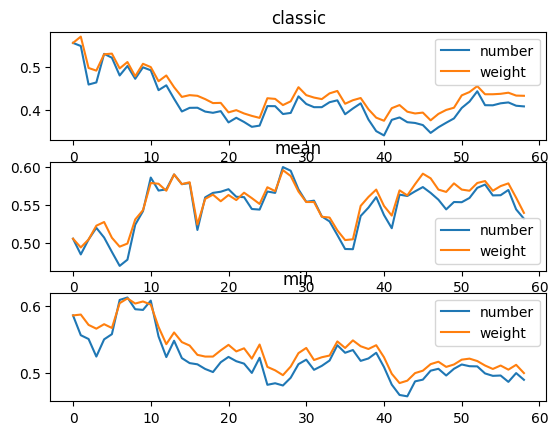

C_2, C_5 as train set and C_1 as test set
For classic, the roc auc is 0.5684476037606053 with k = 33
For classic_weight, the roc auc is 0.5558358174730567 with k = 11
For mean, the roc auc is 0.614308644806237 with k = 7
For mean_weight, the roc auc is 0.6154551708323779 with k = 8
For min, the roc auc is 0.6202705801421693 with k = 6
For min_weight, the roc auc is 0.5980279752350378 with k = 47


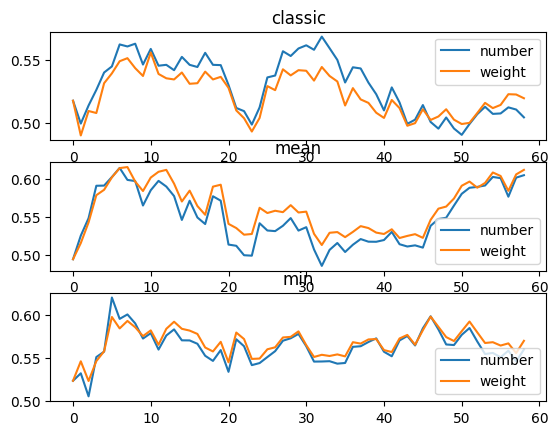

Mean of the cross val


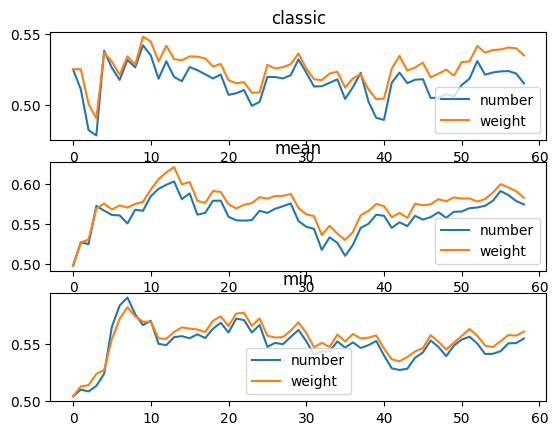

In [54]:
n_max = 60
roc_auc_sum = np.zeros((n_max - 1, 3))
roc_auc_weight_sum = np.zeros((n_max - 1, 3))

for i in range(len(list_cross_val_train)):
    center1, center2 = list_cross_val_train[i]
    center_test = list_cross_val_test[i]
    print(f'{center1}, {center2} as train set and {center_test} as test set')
    
    distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='mean_norm')
    roc_auc, roc_auc_weight = plot_roc(distances_train, y_train, distances_pred, y_test, n_max=60)
    
    roc_auc_sum += roc_auc / 3 
    roc_auc_weight_sum += roc_auc_weight / 3 

print("Mean of the cross val")

fig, axs = plt.subplots(3)
distance = ['classic', 'mean', 'min']
for hausdorf_type in range(3):
    axs[hausdorf_type].set_title(distance[hausdorf_type])
    axs[hausdorf_type].plot(roc_auc_sum[:, hausdorf_type], label='number')
    axs[hausdorf_type].plot(roc_auc_weight_sum[:, hausdorf_type], label='weight')
    axs[hausdorf_type].legend(loc='best')
plt.show()


In [55]:
center1 = 'C_1'
center2 = 'C_2' 
center_test = 'C_5' 

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='mean_norm')

n1, n2, _ = distances_pred.shape

distances_matrix = np.zeros((n1 + n2, n1 + n2, 3))
distances_matrix[:n1, :n1] = distances_train
distances_matrix[:n1, n1:] = distances_pred
distances_matrix[n1:, :n1] = np.moveaxis(distances_pred, 0, 1)
distances_matrix[n1:, n1:] = np.load(f'hausdorf_exp_norm_{center_test}.npy')

y = np.zeros(n1 + n2)
y[:n1] = y_train
y[n1:] = y_test

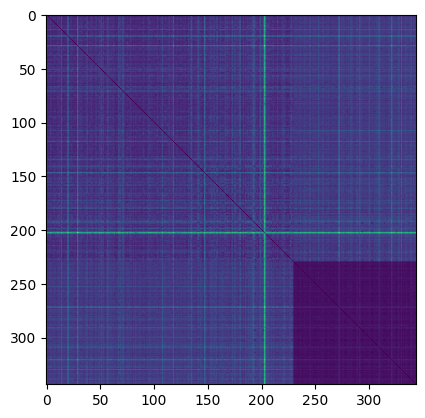

In [56]:
plt.imshow(distances_matrix[:,:,2])

# Test with graphs

In [21]:
import sknetwork as net
from scipy import sparse

In [22]:
seeds = {}
for i in range(y_train.size):
    seeds[i] = y_train[i]

# Try with all the distances
for i in range(3):
    adjacency = sparse.csr_matrix(distances_matrix[:,:,i])

    # PageRank
    print('PageRank')
    pagerank = net.classification.PageRankClassifier()
    y_pred = pagerank.fit_predict(adjacency, seeds)[n1:]
    print(roc_auc_score(y_test, pagerank.score(1)[n1:]))
    print(net.classification.get_confusion_matrix(y_test, y_pred).toarray())

    # Propagation
    print('Propagation')
    propagation = net.classification.Propagation()
    y_pred = propagation.fit_predict(adjacency, seeds)[n1:]
    print(roc_auc_score(y_test, propagation.score(1)[n1:]))
    print(net.classification.get_confusion_matrix(y_test, y_pred).toarray())

    # Diffusion
    print('Diffusion')
    diffusion = net.classification.DiffusionClassifier()
    y_pred = diffusion.fit_predict(adjacency, seeds)[n1:]
    print(roc_auc_score(y_test, diffusion.score(1)[n1:]))
    print(net.classification.get_confusion_matrix(y_test, y_pred).toarray())
    print()


PageRank
0.43126598465473137
[[48 20]
 [36 10]]
Propagation
0.46707161125319685
[[68  0]
 [46  0]]
Diffusion
0.46771099744245515
[[57 11]
 [40  6]]

PageRank
0.40952685421994883
[[44 24]
 [33 13]]
Propagation
0.4082480818414322
[[68  0]
 [46  0]]
Diffusion
0.38810741687979544
[[64  4]
 [46  0]]

PageRank
0.39641943734015345
[[34 34]
 [32 14]]
Propagation
0.4430946291560102
[[68  0]
 [46  0]]
Diffusion
0.3970588235294118
[[27 41]
 [28 18]]



In [23]:
seeds = {}
for i in range(y_train.size):
    seeds[i] = y_train[i]

k_list = np.arange(2, 50, 5)
roc = np.zeros((k_list.size, 3))

for i, k in enumerate(k_list):
    print(k, end=' ')
    knn = net.utils.KNNDense(n_neighbors=k)
    adjacency_k = knn.fit_transform(adjacency.toarray())

    # PageRank
    pagerank = net.classification.PageRankClassifier()
    y_pred = pagerank.fit_predict(adjacency_k, seeds)[n1:]
    roc[i, 0] = roc_auc_score(y_test, pagerank.score(1)[n1:])

    # Propagation
    propagation = net.classification.Propagation()
    y_pred = propagation.fit_predict(adjacency_k, seeds)[n1:]
    roc[i, 1] = roc_auc_score(y_test, propagation.score(1)[n1:])

    # Diffusion
    diffusion = net.classification.DiffusionClassifier()
    y_pred = diffusion.fit_predict(adjacency_k, seeds)[n1:]
    roc[i, 2] = roc_auc_score(y_test, diffusion.score(1)[n1:])


2 7 12 17 22 27 32 37 42 47 